# Programming Exercise 2: Logistic Regression

## Introduction

In this exercise, you will implement logistic regression and apply it to two different datasets. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook. The assignment can be promptly submitted to the coursera grader directly from this notebook (code and instructions are included below).

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, and [`matplotlib`](https://matplotlib.org/) for plotting. In this assignment, we will also use [`scipy`](https://docs.scipy.org/doc/scipy/reference/), which contains scientific and numerical computation functions and tools. 

## 1 Logistic Regression

In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university. Suppose that you are the administrator of a university department and
you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions
decision. Your task is to build a classification model that estimates an applicant’s probability of admission based the scores from those two exams. 

The following cell will load the data and corresponding labels:

In [57]:
import pandas as pd
import numpy as np

In [58]:
students = pd.read_csv("ex2data1.txt", names=["First_Exam", "Second_Exam", "Admission_Status"])
# type casting from pandas series and pandas dataframe to numpy array
X = np.array(students[["First_Exam", "Second_Exam"]])
y = np.array(students["Admission_Status"])
# size of dataset
number_of_samples = y.size
# size of X matrix, m= rows, n= features
m,n = X.shape
print('size of samples: {}'.format(number_of_samples))

size of samples: 100


In [59]:
students.head()

,First_Exam,Second_Exam,Admission_Status
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


### 1.1 Visualizing the data

Before starting to implement any learning algorithm, it is always good to visualize the data if possible.

In [60]:
import matplotlib.pyplot as plt

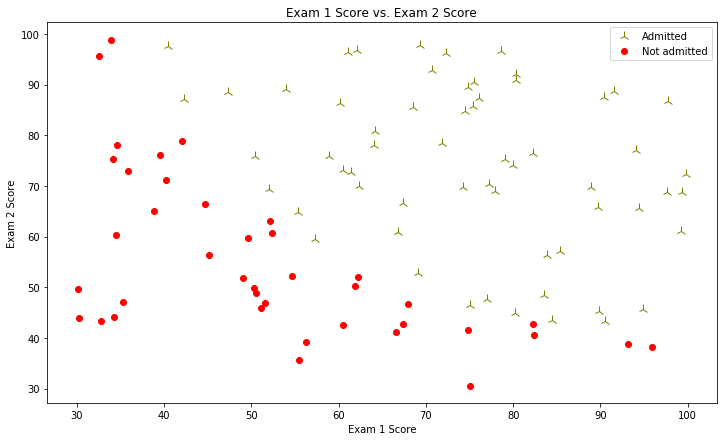

In [61]:
plt.figure(figsize= (12,7))
plt.plot(X[:,0][y == 1], X[:,1][y == 1], "2", ms=10, c= "olive")
plt.plot(X[:,0][y == 0], X[:,1][y == 0], ".", ms=12, c= "red")
plt.legend(["Admitted", "Not admitted"])
plt.xlabel("Exam 1 Score")
plt.ylabel("Exam 2 Score")
plt.title("Exam 1 Score vs. Exam 2 Score")
plt.show()

### 1.2 Implementation

#### 1.2.1 Warmup exercise: sigmoid function

Before you start with the actual cost function, recall that the logistic regression hypothesis is defined as:

$$ h_\theta(x) = g(\theta^T x)$$

where function $g$ is the sigmoid function. The sigmoid function is defined as: 

$$g(z) = \frac{1}{1+e^{-z}}$$.

Your first step is to implement this function `sigmoid` so it can be
called by the rest of your program. When you are finished, try testing a few
values by calling `sigmoid(x)` in a new cell. For large positive values of `x`, the sigmoid should be close to 1, while for large negative values, the sigmoid should be close to 0. Evaluating `sigmoid(0)` should give you exactly 0.5. Your code should also work with vectors and matrices. **For a matrix, your function should perform the sigmoid function on every element.**


In [62]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.
    
    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector 
        or a 2-D matrix. 
    
    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.
        
    Instructions
    ------------
    Compute the sigmoid of each value of z (z can be a matrix, vector or scalar).
    """
    # convert every element to numpy array (matrix, vector or scalar)
    z = np.array(z)
    # create free space as size as input 
    g = np.zeros(z.shape)
    # computing sigmoid function
    g = (1 / (1 + np.exp(-z)))
    
    return g

In [63]:
# test sigmoid function
z = 0
g = sigmoid(z)

print("Actual value of sigmoid(0) should be 0.5")
print("Computed value of sigmoid(0) is {sigmoid}".format(sigmoid= g))

Actual value of sigmoid(0) should be 0.5
Computed value of sigmoid(0) is 0.5


#### 1.2.2 Cost function and gradient

Now you will implement the cost function and gradient for logistic regression. Before proceeding we add the intercept term to X. 

In [64]:
# add intercept term to martix X
X = np.concatenate([np.ones((len(X), 1)), X], axis= 1)

Now, complete the code for the function `cost_function` to return the cost and gradient. Recall that the cost function in logistic regression is

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

and the gradient of the cost is a vector of the same length as $\theta$ where the $j^{th}$
element (for $j = 0, 1, \cdots , n$) is defined as follows:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Note that while this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $h_\theta(x)$.

In [65]:
def cost_function(theta, X, y):
    """
    Compute cost and gradient for logistic regression. 
    
    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).
    
    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the 
        intercept has already been added to the input.
    
    y : arra_like
        Labels for the input. This is a vector of shape (m, ).
    
    Returns
    -------
    J : float
        The computed value for the cost function. 
    
    grad : array_like
        A vector of shape (n+1, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
        
    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to 
    the cost. Compute the partial derivatives and set grad to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Initialize some useful values like number_of_samples, J and grad
    number_of_samples = y.size
    J = 0
    grad = np.zeros(theta.shape)
    # hypothesis function
    h = sigmoid(np.dot(X, theta.T))
    # implementation of J
    J = (1/number_of_samples) * (np.sum(np.dot(-y, np.log(h))) - np.dot((1-y), (np.log(1-h))))
    grad = (1/number_of_samples) * np.dot((h - y), X)
    
    return J, grad

In [66]:
# test multiple theta and check with actual values
initial_theta = np.zeros(n+1)
cost, grad = cost_function(initial_theta, X, y)

print("Cost at initial theta (zeros): {:.3f}".format(cost))
print("Expected cost (approx): 0.693\n")

print("Gradient at initial theta (zeros):")
print("\t[{:.4f}, {:.4f}, {:.4f}]".format(*grad))
print("Expected gradients (approx):\n\t[-0.1000, -12.0092, -11.2628]\n")

# Compute and display cost and gradient with non-zero theta
test_theta = np.array([-24, 0.2, 0.2])
cost, grad = cost_function(test_theta, X, y)

print("Cost at test theta: {:.3f}".format(cost))
print("Expected cost (approx): 0.218\n")

print("Gradient at test theta:")
print("\t[{:.3f}, {:.3f}, {:.3f}]".format(*grad))
print("Expected gradients (approx):\n\t[0.043, 2.566, 2.647]")

Cost at initial theta (zeros): 0.693
Expected cost (approx): 0.693

Gradient at initial theta (zeros):
	[-0.1000, -12.0092, -11.2628]
Expected gradients (approx):
	[-0.1000, -12.0092, -11.2628]

Cost at test theta: 0.218
Expected cost (approx): 0.218

Gradient at test theta:
	[0.043, 2.566, 2.647]
Expected gradients (approx):
	[0.043, 2.566, 2.647]


#### 1.2.3 Learning parameters using `scipy.optimize`

In the previous assignment, you found the optimal parameters of a linear regression model by implementing gradient descent. You wrote a cost function and calculated its gradient, then took a gradient descent step accordingly. This time, instead of taking gradient descent steps, you will use the [`scipy.optimize` module](https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy is a numerical computing library for `python`. It provides an optimization module for root finding and minimization. As of `scipy 1.0`, the function `scipy.optimize.minimize` is the method to use for optimization problems(both constrained and unconstrained).

For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.
Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of X and y values). You will pass to `optimize.minimize` the following inputs:
- `cost_function`: A cost function that, when given the training set and a particular $\theta$, computes the logistic regression cost and gradient with respect to $\theta$ for the dataset (X, y). It is important to note that we only pass the name of the function without the parenthesis. This indicates that we are only providing a reference to this function, and not evaluating the result from this function.
- `initial_theta`: The initial values of the parameters we are trying to optimize.
- `(X, y)`: These are additional arguments to the cost function.
- `jac`: Indication if the cost function returns the Jacobian (gradient) along with cost value. (True)
- `method`: Optimization method/algorithm to use
- `options`: Additional options which might be specific to the specific optimization method. In the following, we only tell the algorithm the maximum number of iterations before it terminates.

If you have completed the `cost_function` correctly, `optimize.minimize` will converge on the right optimization parameters and return the final values of the cost and $\theta$ in a class object. Notice that by using `optimize.minimize`, you did not have to write any loops yourself, or set a learning rate like you did for gradient descent. This is all done by `optimize.minimize`: you only needed to provide a function calculating the cost and the gradient.

In the following, we already have code written to call `optimize.minimize` with the correct arguments.

In [67]:
from scipy import optimize

In [68]:
# define initial values
options= {"maxiter": 400, "disp": True}
initial_theta = np.zeros(n+1)
# optimize cost_function with method= "TNC". for more information check below link
# https://docs.scipy.org/doc/scipy/reference/optimize.minimize-tnc.html#optimize-minimize-tnc
result= optimize.minimize(cost_function, initial_theta, (X, y), jac= True, method= "TNC", options= options)
# put optimizied values in variables
# fun property is minimum value and x is optimized theta
cost_value= result.fun
theta_optimized= result.x

In [69]:
theta_optimized

array([-25.16131863,   0.20623159,   0.20147149])

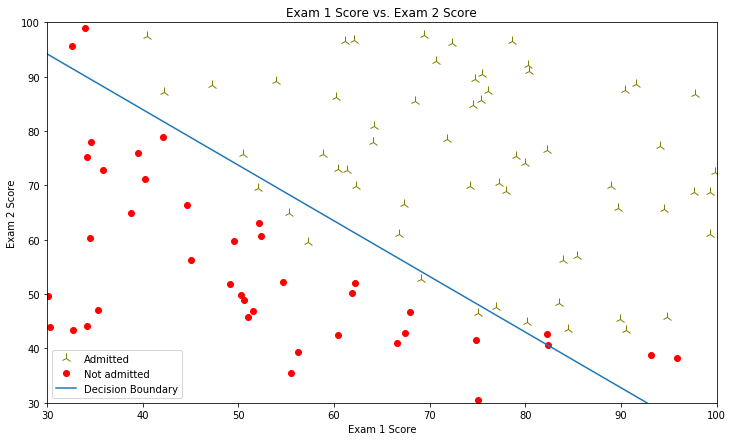

In [119]:
plt.figure(figsize= (12,7))
plt.plot(X[:,1][y == 1], X[:,2][y == 1], "2", ms=10, c= "olive")
plt.plot(X[:,1][y == 0], X[:,2][y == 0], ".", ms=12, c= "red")
plt.xlabel("Exam 1 Score")
plt.ylabel("Exam 2 Score")
plt.title("Exam 1 Score vs. Exam 2 Score")

plot_x = np.array([np.min(X[:, 1]) - 2, np.max(X[:, 1]) + 2])

# Calculate the decision boundary line
plot_y = (-1. / theta_optimized[2]) * (theta_optimized[1] * plot_x + theta_optimized[0])

# Plot, and adjust axes for better viewing
plt.plot(plot_x, plot_y)

# Legend, specific for the exercise
plt.legend(['Admitted', 'Not admitted', 'Decision Boundary'])
plt.xlim([30, 100])
plt.ylim([30, 100])
plt.show()

In [128]:
(-1. / theta_optimized[2]) * (theta_optimized[1] * plot_x + theta_optimized[0])

array([96.16598094, 20.65402819])

In [124]:
(-1. / theta_optimized[2]) * (theta_optimized[1] * plot_x + theta_optimized[0])

array([96.16598094, 20.65402819])

In [125]:
theta_optimized[1] * plot_x + theta_optimized[0]

array([-19.3747031 ,  -4.16119776])

In [126]:
(-1. / theta_optimized[2])

-4.963481527191293